In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose,MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D,concatenate,Activation, ZeroPadding2D,Add
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.initializers import glorot_uniform

In [3]:
#Loading the image and applying the data augmentations such as rotating,flipping 
def LoadImage(name, path="/content/drive/MyDrive/cityscapes_data/train",rotation=0.0, flip=False, cut_bottom=58,size=(256, 256)):
    img = Image.open(path+"/"+name)
    img = np.array(img)
    seg = img[:-cut_bottom, 256:]
    img = img[:-cut_bottom, 0:256]
    
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    

    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]
    return img/255, seg/255


In [4]:
files =os.listdir("/content/drive/MyDrive/cityscapes_data/train")[0:10]


'''
Due to the compression of the JPEG standard, there are more than only a few discrete colors in the segmented image. To 
find the most imortant colors and identify similar colors we can use KMeans clustering. This also allows us to go from a 
color representation to a class representation.
'''


colors = []
for file in files:
    img, seg = LoadImage(file)
    colors.append(seg.reshape(seg.shape[0]*seg.shape[1], 3))
colors = np.array(colors)
colors = colors.reshape((colors.shape[0]*colors.shape[1],3))

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [5]:
'''
After clustering the image contains information about 13 different layers. Computer displays can only utilize the RGB 
colorspace. This function converts the layer representation to a color representation. This is just for visualizing.
'''

def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),(255,255,0), (255,0,255), (0,255,255),(255,255,255), (200,50,0),(50,200,0),(50,0,200), 
              (200,200,50), (0,50,200),(0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

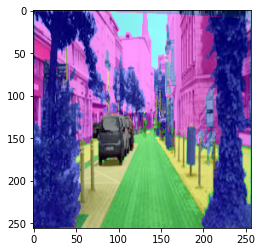

In [7]:
'''
This function converts the discrete color representation (output of the color clustering) to a 13-dimensional class 
representation.
'''

def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(km.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

img, seg = LoadImage("234.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
plt.imshow(total[:,:,:])
plt.show()

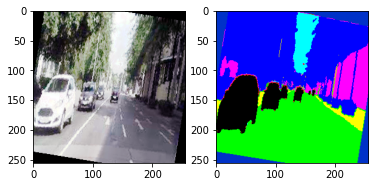

In [9]:
'''
To make training more memory efficient a generator is used for feeding the data to the deep learning algorithm. This 
generator creates batches of e.g. 10 raw-segmented image pairs at a time. It also uses image augmentation and randomly 
flips and rotates the images to increase the effective size of the dataset.
'''


def Generate(path="/content/drive/MyDrive/cityscapes_data/train", batch_size=10,maxangle=10.0):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):
            file = random.sample(files,1)[0]
            
            flip=False
            if random.random() > 0.5:
                flip=True
            
            angle = maxangle*(random.random()*2-1)
            
            img, seg = LoadImage(file, path, rotation=angle, flip=flip)
            
            seg = ColorsToClass(seg)
            
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
gen = Generate()
imgs, segs = next(gen)

plt.subplot(121)
plt.imshow(imgs[0])
plt.subplot(122)
plt.imshow(LayersToRGBImage(segs[0]))
plt.show()

## 1.Training U-NET with categeorical cross entropy as loss and metric as accuracy 

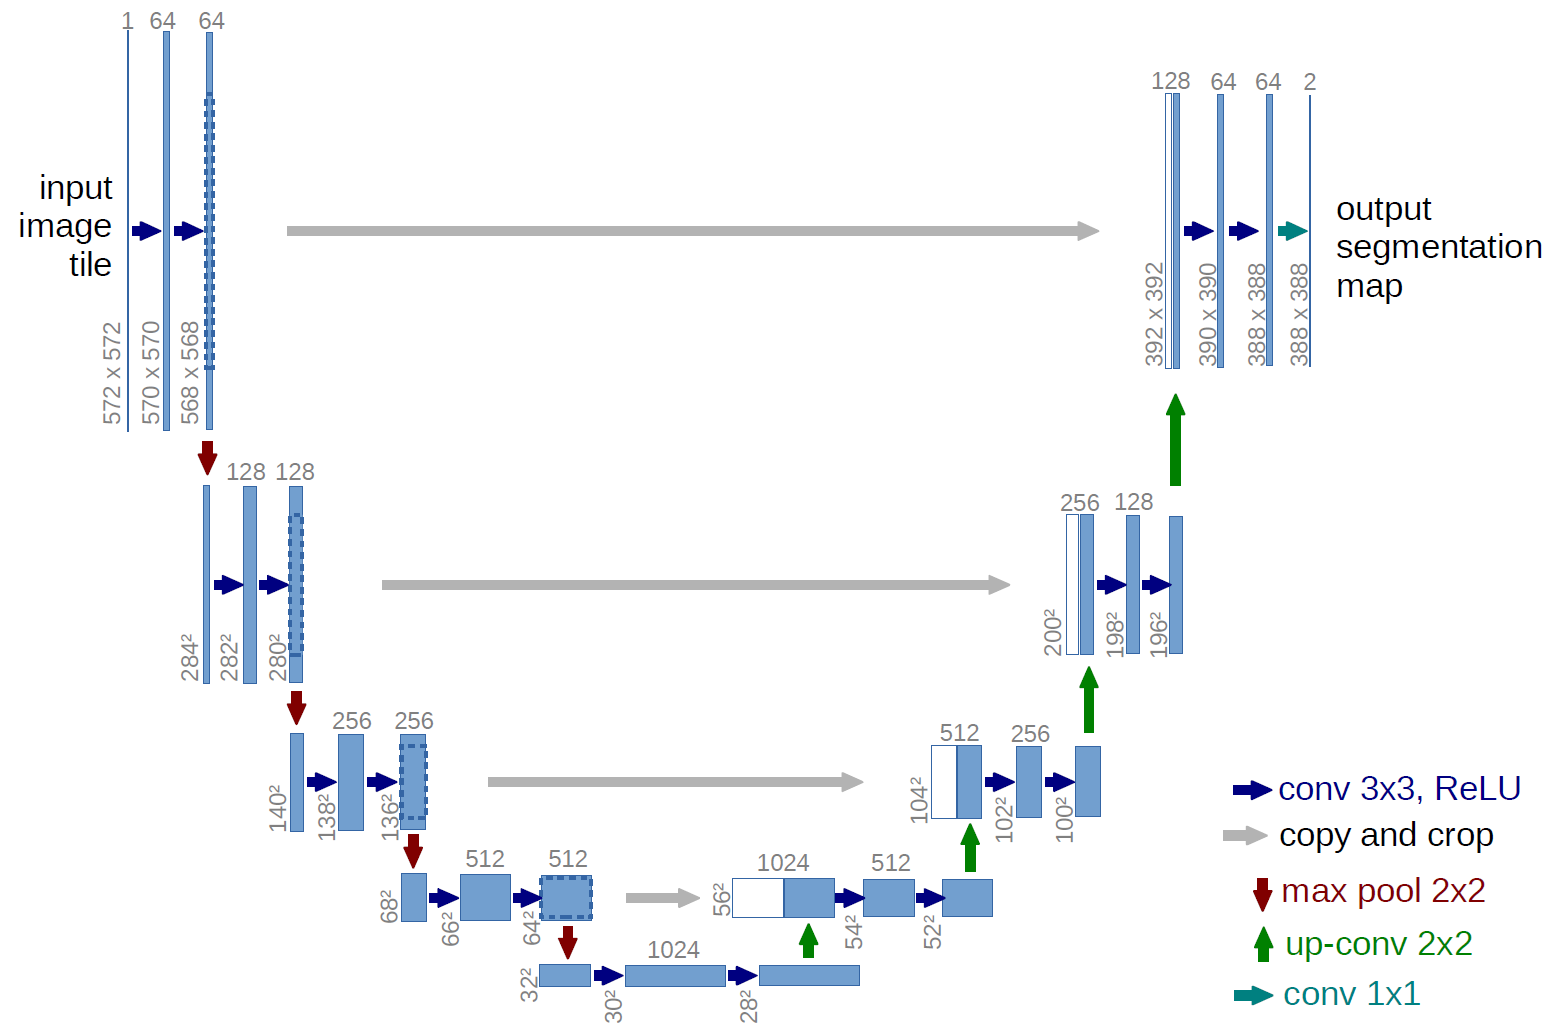

In [4]:
from IPython.display import Image
Image(filename='u-net-architecture.png',width=700)

In [10]:
#https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

inputs = Input(shape= (256, 256, 3))
conv_1 = Conv2D(64, (3, 3), padding='same')(inputs)
act_1 = Activation('relu')(conv_1)
conv_1 = Conv2D(64, (3, 3), padding='same')(act_1)
bn_1 = BatchNormalization(axis=3)(conv_1)
act_1 = Activation('relu')(bn_1)
pool_1 = MaxPooling2D()(act_1)

conv_2 = Conv2D(128, (3, 3), padding='same')(pool_1)
act_2 = Activation('relu')(conv_2)
conv_2 = Conv2D(128, (3, 3), padding='same')(act_2)
bn_2 = BatchNormalization(axis=3)(conv_2)
act_2 = Activation('relu')(bn_2)
pool_2 = MaxPooling2D()(act_2)

conv_3 = Conv2D(256, (3, 3), padding='same')(pool_2)
act_3 = Activation('relu')(conv_3)
conv_3 = Conv2D(256, (3, 3), padding='same')(act_3)
bn_3 = BatchNormalization(axis=3)(conv_3)
act_3 = Activation('relu')(bn_3)
pool_3 = MaxPooling2D()(act_3)

conv_4 = Conv2D(512, (3, 3), padding='same')(pool_3)
act_4 = Activation('relu')(conv_4)
conv_4 = Conv2D(512, (3, 3), padding='same')(act_4)
bn_4 = BatchNormalization(axis=3)(conv_4)
act_4 = Activation('relu')(bn_4)
pool_4 = MaxPooling2D()(act_4)

conv_5 = Conv2D(1024, (3, 3), padding='same')(pool_4)
act_5 = Activation('relu')(conv_5)
conv_5 = Conv2D(1024, (3, 3), padding='same')(act_5)
bn_5 = BatchNormalization(axis=3)(conv_5)
act_5 = Activation('relu')(bn_5)

up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(act_5), conv_4])
conv_6 = Conv2D(512, (3, 3), padding='same')(up6)
act_6 = Activation('relu')(conv_6)
conv_6 = Conv2D(512, (3, 3), padding='same')(act_6)
bn_6 = BatchNormalization(axis=3)(conv_6)
act_6 = Activation('relu')(bn_6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(act_6), conv_3])
conv_7 = Conv2D(256, (3, 3), padding='same')(up7)
act_7 = Activation('relu')(conv_7)
conv_7 = Conv2D(256, (3, 3), padding='same')(act_7)
bn_7 = BatchNormalization(axis=3)(conv_7)
act_7 = Activation('relu')(bn_7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(act_7), conv_2])
conv_8 = Conv2D(128, (3, 3), padding='same')(up8)
act_8 = Activation('relu')(conv_8)
conv_8 = Conv2D(128, (3, 3), padding='same')(act_8)
bn_8 = BatchNormalization(axis=3)(conv_8)
act_8 = Activation('relu')(bn_8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(act_8), conv_1])
conv_9 = Conv2D(64, (3, 3), padding='same')(up9)
act_9 = Activation('relu')(conv_9)
conv_9 = Conv2D(64, (3, 3), padding='same')(act_9)
bn_9 = BatchNormalization(axis=3)(conv_9)
act_9 = Activation('relu')(bn_9)

conv10 = Conv2D(13, (1, 1), activation='sigmoid')(act_9)
model1=Model(inputs=[inputs], outputs=[conv10])
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

In [11]:
train_gen = Generate()
val_gen = Generate("/content/drive/MyDrive/cityscapes_data/val")

In [12]:
opt = Adam(lr=0.0001)
model1.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])

In [13]:
callbacks = [ModelCheckpoint("loss.h5", save_best_only=True, verbose=0)]
history = model1.fit_generator(train_gen, epochs=300, steps_per_epoch=10,validation_data=val_gen, validation_steps=10,
                               callbacks=callbacks,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
10/10 [==============================] - 100s 6s/step - loss: 2.1889 - accuracy: 0.1965 - val_loss: 2.3353 - val_accuracy: 0.1874
Epoch 2/300
10/10 [==============================] - 50s 5s/step - loss: 1.6226 - accuracy: 0.4860 - val_loss: 2.2994 - val_accuracy: 0.2382
Epoch 3/300
10/10 [==============================] - 43s 5s/step - loss: 1.2808 - accuracy: 0.5580 - val_loss: 2.3219 - val_accuracy: 0.2494
Epoch 4/300
10/10 [==============================] - 42s 5s/step - loss: 1.2211 - accuracy: 0.5784 - val_loss: 2.3753 - val_accuracy: 0.2567
Epoch 5/300
10/10 [==============================] - 35s 4s/step - loss: 1.1381 - accuracy: 0.6016 - val_loss: 2.3154 - val_accuracy: 0.2500
Epoch 6/300
10/10 [==============================] - 35s 4s/step - loss: 1.0273 - accuracy: 0.6354 - val_loss: 2.3679 - val_accuracy: 0.2582
Epoch 7/300
10/10 [==============================] - 32s 3s/step - loss: 1.0291 - accuracy: 0.6271 - val_loss: 2.4366 - val_accuracy: 0.2503
Epoch 8/300


In [14]:
model1.save("model1.h5")
model1 = load_model("loss.h5")

In [15]:
loss=history.history["loss"]
acc=history.history["accuracy"]
val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

Text(0, 0.5, 'Accuracy')

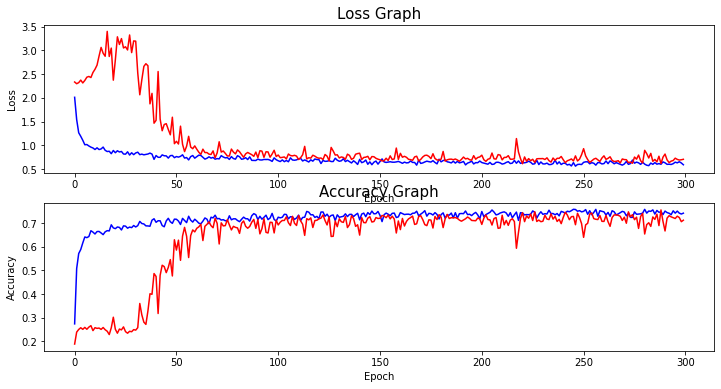

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Loss Graph",fontsize = 15)
plt.plot(loss, 'b-')
plt.plot(val_loss,'r-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(212)
plt.title("Accuracy Graph",fontsize = 15)
plt.plot(acc, 'b-')
plt.plot(val_acc,'r-')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
inputs = Input(shape= (256, 256, 3))
conv0_0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv0_0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_0)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
 
conv1_0 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv1_0 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_0)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
 
up1_0 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1_0)
merge00_10 = concatenate([conv0_0,up1_0])
conv0_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge00_10)
conv0_1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_1)

conv2_0 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv2_0 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_0)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
 
up2_0 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2_0)
merge10_20 = concatenate([conv1_0,up2_0])
conv1_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_20)
conv1_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
 
up1_1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1_1)
merge01_11 = concatenate([conv0_0,conv0_1,up1_1])
conv0_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge01_11)
conv0_2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_2)
 
conv3_0 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv3_0 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_0)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

up3_0 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv3_0)
merge20_30 = concatenate([conv2_0,up3_0])
conv2_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge20_30)
conv2_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
 
up2_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2_1)
merge11_21 = concatenate([conv1_0,conv1_1,up2_1])
conv1_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge11_21)
conv1_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_2)
 
up1_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1_2)
merge02_12 = concatenate([conv0_0,conv0_1,conv0_2,up1_2])
conv0_3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge02_12)
conv0_3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_3)
 
conv4_0 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv4_0 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4_0)
up4_0 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv4_0)
merge30_40 = concatenate([conv3_0,up4_0])
conv3_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge30_40)
conv3_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
 
up3_1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv3_1)
merge21_31 = concatenate([conv2_0,conv2_1,up3_1])
conv2_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge21_31)
conv2_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_2)
 
up2_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv2_2)
merge12_22 = concatenate([conv1_0,conv1_1,conv1_2,up2_2])
conv1_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge12_22)
conv1_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_3)
up1_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1_3)
merge03_13 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up1_3])
conv0_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
conv0_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)

conv0_4 = Conv2D(13,1, activation = 'softmax')(conv0_4)
 
model2= Model(input = inputs, output = conv0_4)
opt = Adam(lr=0.0001)
model2.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_24[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
callbacks1 = [ModelCheckpoint("loss_model_2.h5", save_best_only=True, verbose=0)]
history2=model2.fit_generator(train_gen, epochs=300, steps_per_epoch=10,validation_data=val_gen, validation_steps=10,
                          callbacks=callbacks1, verbose=1)

Epoch 1/300
10/10 [==============================] - 46s 5s/step - loss: 2.0248 - accuracy: 0.2781 - val_loss: 1.9864 - val_accuracy: 0.3773
Epoch 2/300
10/10 [==============================] - 20s 2s/step - loss: 1.7620 - accuracy: 0.4004 - val_loss: 1.7229 - val_accuracy: 0.3999
Epoch 3/300
10/10 [==============================] - 19s 2s/step - loss: 1.7014 - accuracy: 0.4105 - val_loss: 1.6738 - val_accuracy: 0.4261
Epoch 4/300
10/10 [==============================] - 19s 2s/step - loss: 1.5949 - accuracy: 0.4620 - val_loss: 1.7985 - val_accuracy: 0.4792
Epoch 5/300
10/10 [==============================] - 19s 2s/step - loss: 1.4354 - accuracy: 0.5082 - val_loss: 1.4484 - val_accuracy: 0.4639
Epoch 6/300
10/10 [==============================] - 20s 2s/step - loss: 1.3104 - accuracy: 0.5361 - val_loss: 1.3908 - val_accuracy: 0.5440
Epoch 7/300
10/10 [==============================] - 20s 2s/step - loss: 1.2645 - accuracy: 0.5600 - val_loss: 1.3055 - val_accuracy: 0.5341
Epoch 8/300
1

In [ ]:
history2=model2.fit_generator(train_gen, epochs=100, steps_per_epoch=10,validation_data=val_gen, validation_steps=10,
                          callbacks=callbacks1, verbose=1)

Epoch 1/100
10/10 [==============================] - 20s 2s/step - loss: 0.6013 - accuracy: 0.7629 - val_loss: 0.5907 - val_accuracy: 0.7606
Epoch 2/100
10/10 [==============================] - 20s 2s/step - loss: 0.5621 - accuracy: 0.7768 - val_loss: 0.6897 - val_accuracy: 0.7494
Epoch 3/100
10/10 [==============================] - 20s 2s/step - loss: 0.5820 - accuracy: 0.7659 - val_loss: 0.7618 - val_accuracy: 0.7497
Epoch 4/100
10/10 [==============================] - 19s 2s/step - loss: 0.6198 - accuracy: 0.7645 - val_loss: 0.6257 - val_accuracy: 0.7771
Epoch 5/100
10/10 [==============================] - 19s 2s/step - loss: 0.5335 - accuracy: 0.7859 - val_loss: 0.4946 - val_accuracy: 0.7606
Epoch 6/100
10/10 [==============================] - 19s 2s/step - loss: 0.5858 - accuracy: 0.7672 - val_loss: 0.4891 - val_accuracy: 0.7639
Epoch 7/100
10/10 [==============================] - 20s 2s/step - loss: 0.5393 - accuracy: 0.7801 - val_loss: 0.6161 - val_accuracy: 0.7728
Epoch 8/100
1

In [ ]:
model2.save("model2.h5")
model2 = load_model("loss_model_2.h5")

In [ ]:
loss=history2.history["loss"]
acc=history2.history["accuracy"]
val_loss = history2.history["val_loss"]
val_acc = history2.history["val_accuracy"]

Text(0, 0.5, 'Accuracy')

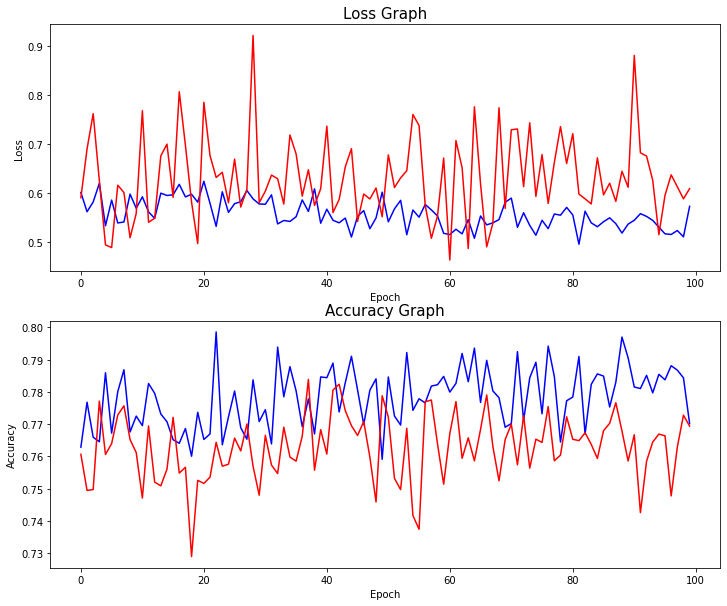

In [ ]:
plot.figure(figsize=(12, 10))
plot.subplot(211)
plot.title("Loss Graph",fontsize = 15)
plot.plot(loss, 'b-')
plot.plot(val_loss,'r-')
plot.xlabel("Epoch")
plot.ylabel("Loss")
plot.subplot(212)
plot.title("Accuracy Graph",fontsize = 15)
plot.plot(acc, 'b-')
plot.plot(val_acc,'r-')
plot.xlabel("Epoch")
plot.ylabel("Accuracy")

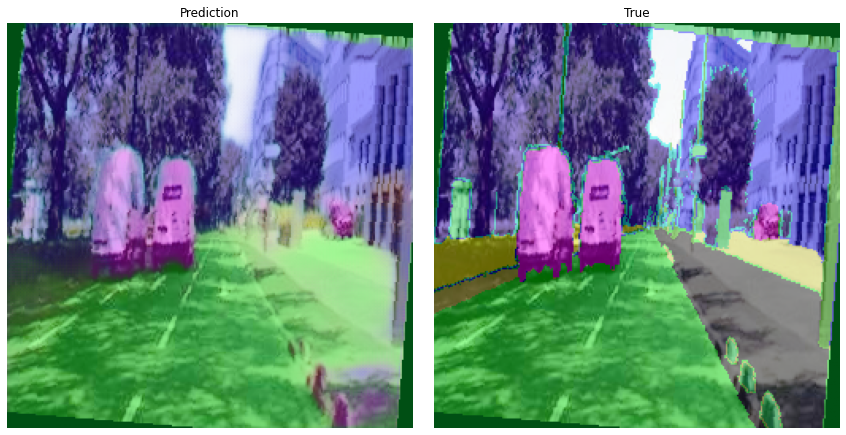

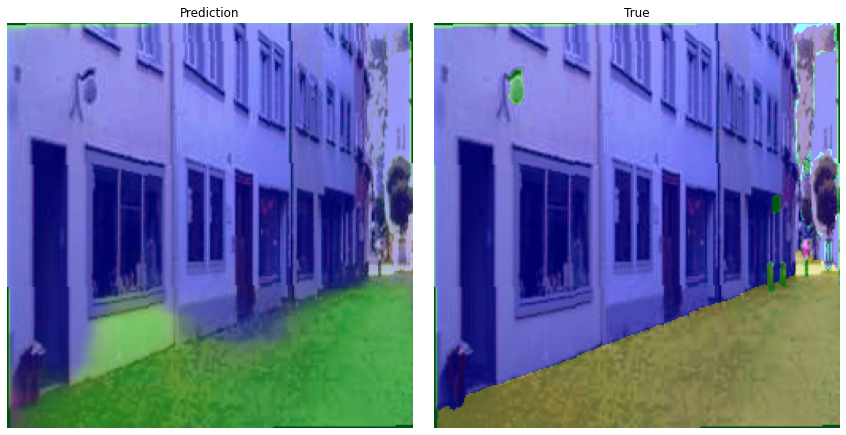

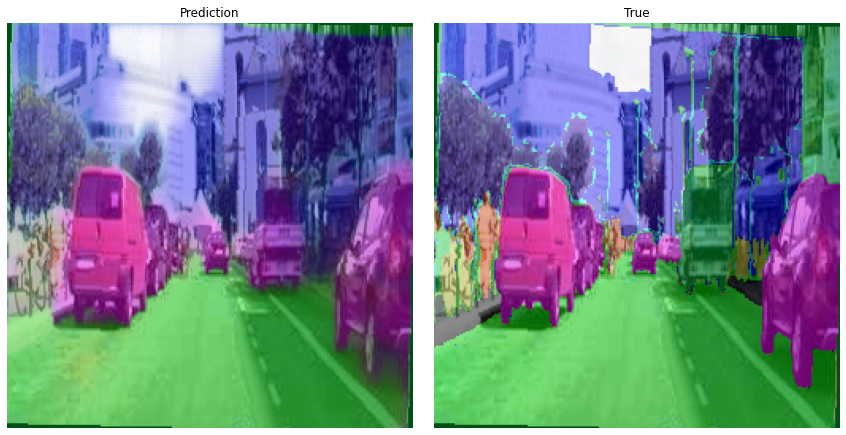

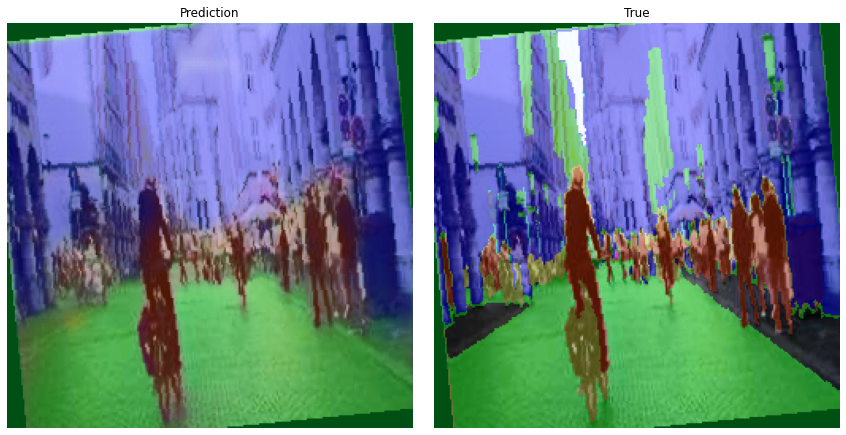

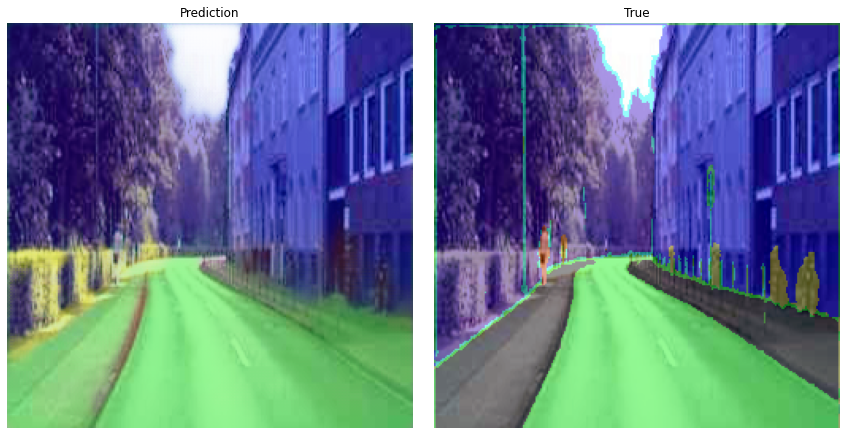

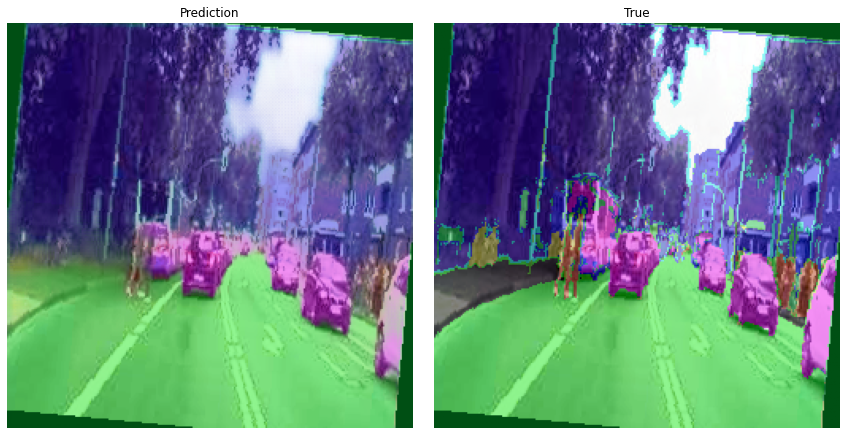

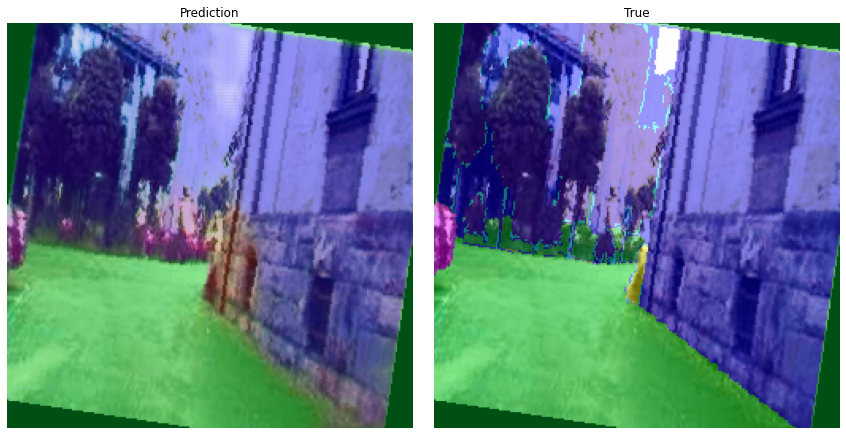

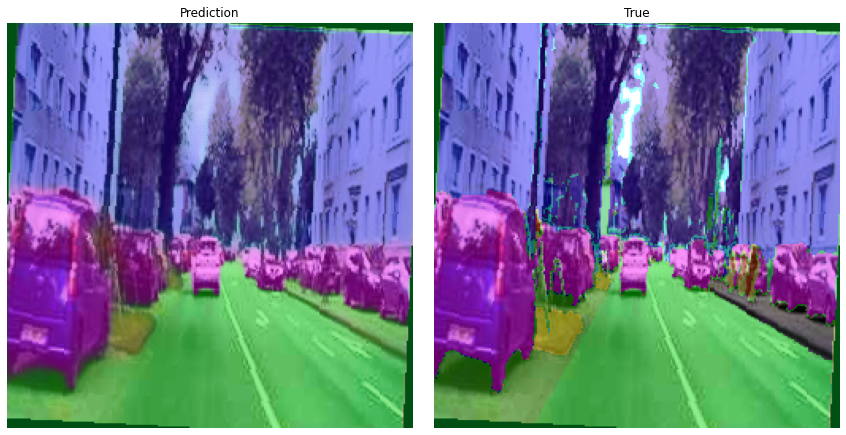

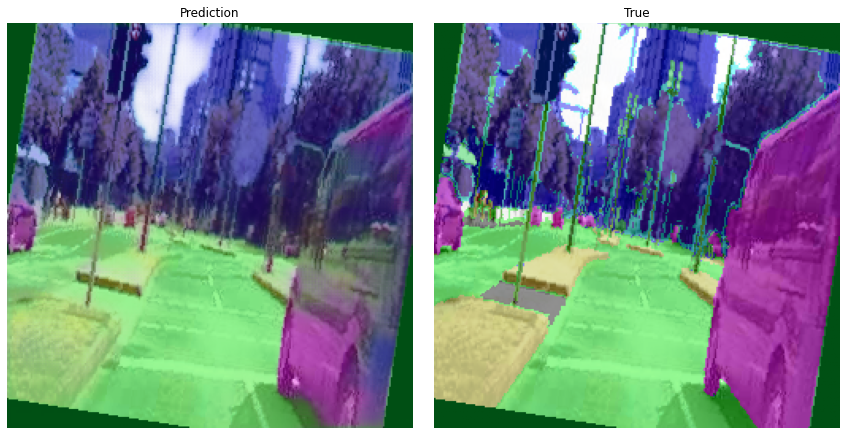

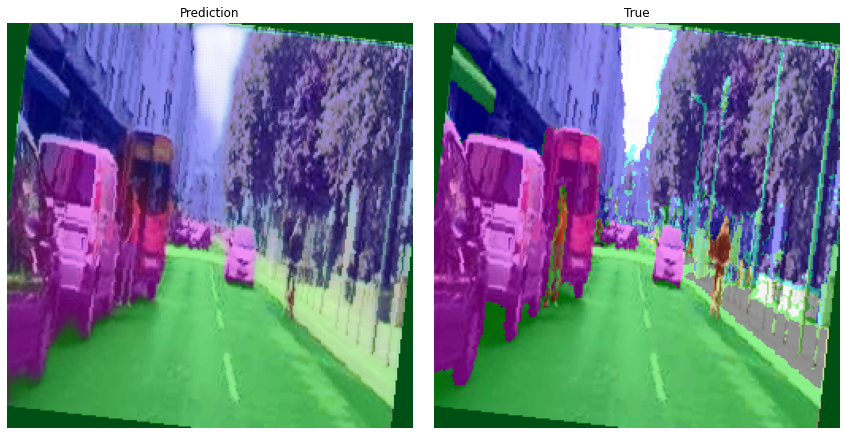

In [ ]:
test_gen = Generate("/content/drive/MyDrive/cityscapes_data/val")
max_show=20
for imgs, segs in test_gen:
    p = model2.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = LayersToRGBImage(p[i])
        _s = LayersToRGBImage(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.6, _p, 0.4, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.6, _s, 0.4, 0)
        plot.figure(figsize=(12,6))
        plot.subplot(121)
        plot.title("Prediction")
        plot.imshow(predimg)
        plot.axis("off")
        plot.subplot(122)
        plot.title("True")
        plot.imshow(trueimg)
        plot.axis("off")
        plot.tight_layout()
        plot.savefig("pred_"+str(i)+".png", dpi=150)
        plot.show()
    break